Nivethitha Ramachandar 
nramachandar@scu.edu

## Pokemon Battle Analysis


Having been a fan of pokemon for long, this analysis is only a guilty-pleasure, this dataset consists of Pokemon's features and their battle statistics.

We will be merging the data sets on the Pokedex number which is uniform through-out and find out how the individual pokemon's and their respective types fare.

In [155]:
#https://www.kaggle.com/terminus7/pokemon-challenge
# importing all the libraries we would need for our analysis


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# this will hide all the warnings that might occur, genrally not advisable, but!

import warnings
warnings.filterwarnings("ignore")


#The main dataset

pokemon = pd.read_csv('pokemon.csv')

# the second column is the number unique to a pokemon which was with a # in the original dataset, renaming it to Pokedex
pokemon = pokemon.rename(index=str, columns={"#": "Pokedex"})
pokemon.head()

,Pokedex,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [156]:
# The fights and combats datasets
fights = pd.read_csv('combats.csv')
fights.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [157]:
# the dataset for which i want to predict an outcome

poke_stat = pd.read_csv('tests.csv')
poke_stat.head()

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115
3,195,618
4,27,656


In [158]:
# Checking to see if there are null values in any of my datasets and validating them 

pokemon.isnull().sum()

Pokedex         0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [159]:
# no of rows and columns
pokemon.shape

(800, 12)

In [160]:
fights.isnull().sum()

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

In [161]:
fights.shape

(50000, 3)

In [162]:
poke_stat.isnull().sum()

First_pokemon     0
Second_pokemon    0
dtype: int64

In [163]:
poke_stat.shape
poke_stat.head()

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115
3,195,618
4,27,656


In [164]:
# Figuring out the row that has the null value in the name

print(pokemon[pokemon['Name'].isnull()])

    Pokedex Name    Type 1 Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
62       63  NaN  Fighting    NaN  65     105       60       60       70   

    Speed  Generation  Legendary  
62     95           1      False  


In [165]:
# used https://www.pokemon.com/us/pokedex/ to find out the pokemon with the ID=63
# it was after Mankey and therefore is primeape
pokemon['Name'][63] = 'Primeape'


### Here on I am going to group the first pokemon's wins and then the second pokemon's wins and then the total wins

In [166]:
poke_winner_1 = fights.groupby('First_pokemon').count()
poke_winner_1.shape
print("My Pokemon by the First type has won " + str(poke_winner_1.shape))

poke_winner_2 = fights.groupby('Second_pokemon').count()
poke_winner_2.shape
print("My Pokemon by the Second type has won " + str(poke_winner_1.shape))

total_poke_winner = fights.groupby('Winner').count()
total_poke_winner.shape
print("Total wins " + str(total_poke_winner.shape))

My Pokemon by the First type has won (784, 2)
My Pokemon by the Second type has won (784, 2)
Total wins (783, 2)


### Looks like there is one pokemon that hasn't won even a single match

In [167]:
# -1 at the end because the pokedex number and the index is differnt by 1
who_lost = np.setdiff1d(poke_winner_1.index.values, total_poke_winner.index.values)-1
who_lost_now = pokemon.iloc[who_lost[0],]
print(who_lost_now)

Pokedex           231
Name          Shuckle
Type 1            Bug
Type 2           Rock
HP                 20
Attack             10
Defense           230
Sp. Atk            10
Sp. Def           230
Speed               5
Generation          2
Legendary       False
Name: 230, dtype: object


#### It is fine that Shuckle hasn't won a single match, atleast he tried!
### I'm now going to merge the datasets together to have the fight count for the individual pokemons as per their pokedex number which is common on all three files

In [168]:
total_poke_winner = total_poke_winner.sort_index()
total_poke_winner['Total Fights'] = poke_winner_1.Winner + poke_winner_2.Winner
total_poke_winner['Win Percentage']= total_poke_winner.First_pokemon/total_poke_winner['Total Fights']

# merge the match victory dataset and the original pokemon dataset
pokemon_new = pd.merge(pokemon, total_poke_winner, left_on='Pokedex', right_index = True, how='left')
pokemon_new[pokemon_new['Win Percentage'].isnull()]

# the above line of code gives the null data for the win percentage, we will drop these later on 
#when we start prepping the data for machine learning model

,Pokedex,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,Total Fights,Win Percentage
11,12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False,NaN,NaN,NaN,NaN
32,33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False,NaN,NaN,NaN,NaN
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False,NaN,NaN,NaN,NaN
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False,NaN,NaN,NaN,NaN
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False,NaN,NaN,NaN,NaN
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,NaN,NaN,NaN,NaN
143,144,Ditto,Normal,NaN,48,48,48,48,48,48,1,False,NaN,NaN,NaN,NaN
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,False,NaN,NaN,NaN,NaN
230,231,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False,NaN,NaN,NaN,NaN
235,236,Ursaring,Normal,NaN,90,130,75,75,75,55,2,False,NaN,NaN,NaN,NaN


### We will now see the top 5 winners and the pokemons with the minimal win percentage


In [169]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.isfinite.html
#to use the above documentation to take finite values in the df and not the null values

pokemon_new[np.isfinite(pokemon_new['Win Percentage'])].sort_values(by = ['Win Percentage']).head()

,Pokedex,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,Total Fights,Win Percentage
289,290,Silcoon,Bug,NaN,50,35,55,25,25,15,3,False,3.0,3.0,138.0,0.021739
189,190,Togepi,Fairy,NaN,35,20,65,40,65,20,2,False,3.0,3.0,122.0,0.024590
638,639,Solosis,Psychic,NaN,45,30,40,105,50,20,5,False,4.0,4.0,129.0,0.031008
236,237,Slugma,Fire,NaN,40,40,40,70,40,20,2,False,4.0,4.0,123.0,0.032520
576,577,Munna,Psychic,NaN,76,25,45,67,55,24,5,False,5.0,5.0,128.0,0.039062


### Pokemon with the maximun win percentage

In [170]:
pokemon_new[np.isfinite(pokemon_new['Win Percentage'])].sort_values(by = ['Win Percentage'], ascending = False).head()

,Pokedex,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,Total Fights,Win Percentage
154,155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,1,False,127.0,127.0,129.0,0.984496
512,513,Weavile,Dark,Ice,70,120,65,45,85,125,4,False,116.0,116.0,119.0,0.974790
703,704,Tornadus Therian Forme,Flying,NaN,79,100,80,110,90,121,5,True,121.0,121.0,125.0,0.968000
19,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,1,False,115.0,115.0,119.0,0.966387
153,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,1,False,136.0,136.0,141.0,0.964539


### Let me also do an aggregate of how each Type of pokemon has fared in the win percentage, after all while dealing with them i should know what my prospects are of winning!

In [171]:
pokemon_new.groupby('Type 1').agg({'Win Percentage': 'mean'}).sort_values(by = 'Win Percentage')

,Win Percentage
Type 1,
Fairy,0.329300
Rock,0.404852
Steel,0.424529
Poison,0.433262
Bug,0.439006
Ice,0.439604
Grass,0.440364
Water,0.469357
Fighting,0.475616


## Analysis!!


### 1. Here is the plot of each type of pokemon against their win percentage


###  All through we have heard that the strongest pokemons are Psychic, but the top three contenders are steel, fairy and dragon. Being strong is something, winning the matches is another, don't we all know the story of David and Goliath!


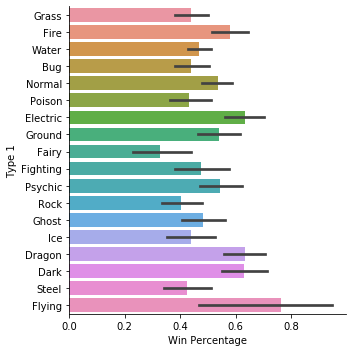

In [172]:
sns.factorplot(x = 'Win Percentage', y = 'Type 1', data = pokemon_new, kind = 'bar')

#### What I am surprised about is Steel being one of the strongest pokemon types has a mediocre win percentage, 50% to be honest!

### Assuming i am a trainer and using the above graph i know that flying, electric , dark, dragon and fire type pokemon have the highest win %. Now i want to start collecting these pokemon. How can i do that and how is their availabilty spread in the wild. 

Text(0.5, 0, "Pokemon's Type 1")

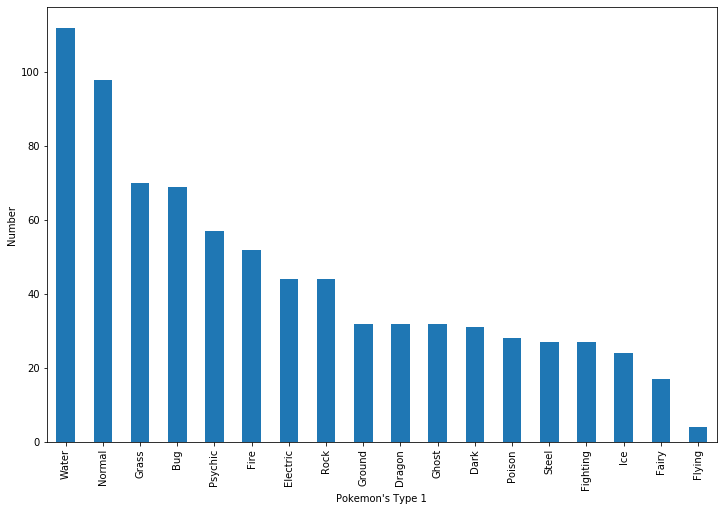

In [173]:
mytype_pokemon = pokemon['Type 1']
fig, ax = plt.subplots(1, 1, figsize=(12,8))
mytype_pokemon.value_counts().plot(kind='bar', ax = ax)
ax.set_ylabel("Number")
ax.set_xlabel("Pokemon's Type 1")

#### We can see from above that Water types of pokemon are the max in number but they are in the lower end of the winning range

#### And surprisingly Dark and Dragon have scored very well in the winnings but their availability are very low.  One smart thing to do would be to not collect the rarely available Flying type pokemon and instead invest my time in finding out Electric or Dark which are nominally available and have a fair win %


### Now this gets me curious, is it because each of these types have a different speed, attack and defense range that enables them to win even being in the lower end of the spectrum? Are their attacks much better than their defenses and vice-versa.?



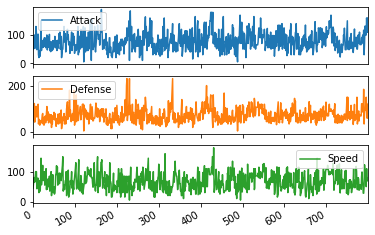

In [174]:
poke_attack = pokemon.loc[:,['Attack', 'Defense', 'Speed']]
poke_attack.plot(subplots = True)
plt.show()

## 3. Machine Learning Model

### Data Visualization

#### Let us see if there are any correlations in our data, before we prepare our data for building, training and testing

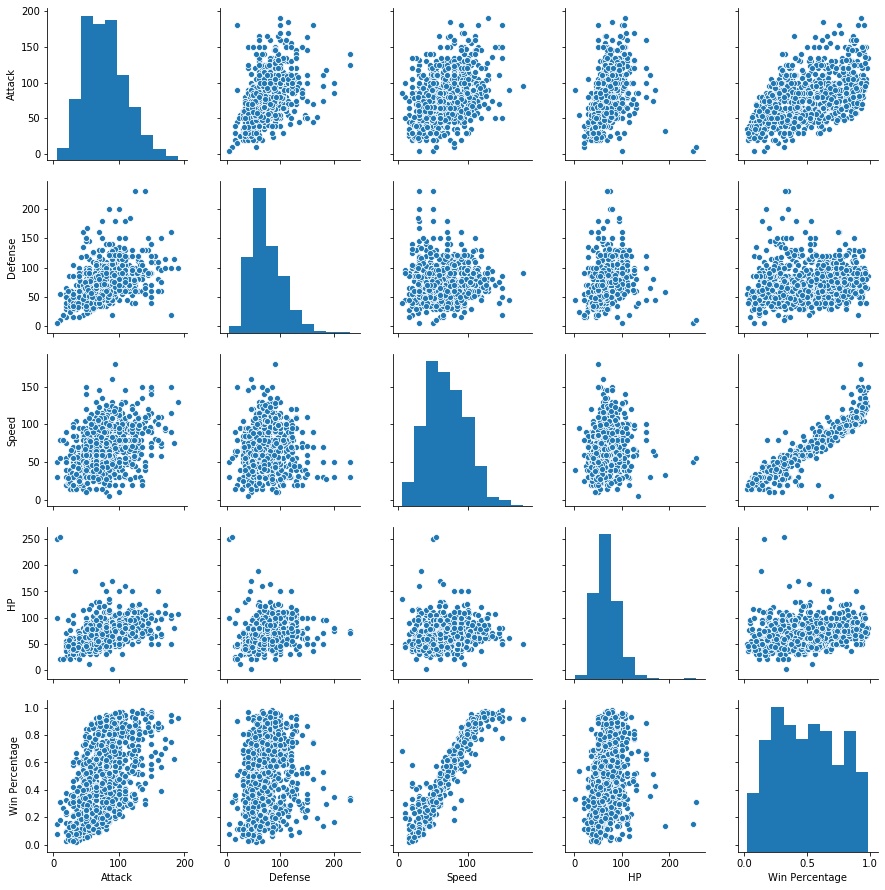

In [175]:
sns.pairplot(pokemon_new[['Attack', 'Defense', 'Speed', 'HP', 'Win Percentage']].dropna())


We see that the speed against win percentage is positively correlated, with highly positive linearity

## We are now going to prep our data and create our model to predict the winner when one pokemon is pitted against another

In [176]:
pokemon = pd.read_csv('pokemon.csv', index_col=0)
analysisdata = pokemon
analysisdata.head()


,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


********

We will be only using the columns as mentioned in the function predictionFunction for our training data.
we are essentially taking our original pokemon data and then the combat data.
We are replacing the pokedex numbers with their names and then we are going to make a differnce between our qualifiers
This will give us a maximum and minimum value in each of the qualifier

********

In [177]:

fights=pd.read_csv('combats.csv')

#these are the columns that is going to help us train our model to predict
value = ["First_pokemon","Second_pokemon","Winner"]
new_fights_data=fights[value].replace(analysisdata.Name)
new_fights_data.head()

# the fights data set had pokedex numbers in them, pretty confusing it was so we changed it to their names

,First_pokemon,Second_pokemon,Winner
0,Larvitar,Nuzleaf,Nuzleaf
1,Virizion,Terrakion,Terrakion
2,Togetic,Beheeyem,Beheeyem
3,Slugma,Druddigon,Druddigon
4,Omastar,Shuckle,Omastar


In [178]:
fights.Winner[fights.Winner == fights.First_pokemon] = 0
fights.Winner[fights.Winner == fights.Second_pokemon] = 1
# here we are assigning 0 and 1 to the loser and winner respectively

In [179]:
def predictionFunction(dataframe):
    # converting the columns we are interested in into a list
    train_parameters=["HP","Attack","Defense","Sp. Atk","Sp. Def","Speed","Legendary"]
    train_parameters_df=analysisdata[train_parameters].T.to_dict("list")
    #Used for substituting each value in a Series with another value, that is derived from a series 
    firstpoke=dataframe.First_pokemon.map(train_parameters_df)
    secondpoke=dataframe.Second_pokemon.map(train_parameters_df)
    my_list=[]
    # storing the difference of train_parameters in a seperate list my_list
    for i in range(len(firstpoke)):
        my_list.append(np.array(firstpoke[i])-np.array(secondpoke[i]))
    new_test = pd.DataFrame(my_list, columns=train_parameters)
    # calculating the Winner value for each train_parameters
    for each in train_parameters:
        description=new_test[each].describe()
        new_test[each]=(new_test[each]-description['min'])/(description['max']-description['min'])
    return new_test

finals= predictionFunction(fights)
finals = pd.concat([finals,fights.Winner], axis=1)

Here we are using the Random Forest Classifier to train the model and we are going to test the model using the test
data that is given as a separate csv. The test data has 10000 rows of combinations of pokemons against each other


In [180]:
X_label=finals.drop("Winner",axis=1)
# X_label is all the test determining columns except the winner
#y_label is just the winner
y_label = finals["Winner"]

#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.33, random_state=42)
# we are using the default values that sklearn gave, for test_size and the random_state

#the new n-estimator for the classifier is 100
clf = RandomForestClassifier(n_estimators=100)
my_clf = clf.fit(X_train, y_train)
pred = my_clf.predict(X_test)
print('Accuracy of ', accuracy_score(pred, y_test)*100)


#test_data=pd.read_csv("tests.csv")
new_poke_stat = poke_stat[["First_pokemon","Second_pokemon"]].replace(analysisdata.Name)
new_poke_stat.head()



pred_result = predictionFunction(poke_stat)
pred = my_clf.predict(pred_result)
poke_stat["Winner"] = [poke_stat["First_pokemon"][i] if pred[i] == 0 else poke_stat["Second_pokemon"][i] for i in range(len(pred))]

pit_against = poke_stat[cols].replace(analysisdata.Name)
pit_against[5176:5177]
#dodrio a normal type pokemon is no match for the electric Deoxys

Accuracy of  94.8969696969697


,First_pokemon,Second_pokemon,Winner
5176,Dodrio,Deoxys Normal Forme,Deoxys Normal Forme


In [181]:
pit_against[764:765]
# we are pitting Amaura against Hippopotas and our predictor presicts Amaura will win
# Amaura is a ice, type 2 rock
#Hippopotas is a ground type pokemon
# Amaura wins!

,First_pokemon,Second_pokemon,Winner
764,Amaura,Hippopotas,Amaura


In [182]:
pit_against[456:457]
# here Swablu is againt simisear and we know simisear will win
# Swablu is a normal type pokemon
#Simisear is a Fire
# Fire is more competitive against normal pokemon

,First_pokemon,Second_pokemon,Winner
456,Swablu,Simisear,Simisear


In [183]:
pit_against[3133:3134]
# Corphish against Skiploom and Skiploom wins
# Corphish is a water
# Skiploom is a grass type 2 flying pokemon hence the advantage even though type 1 graph above shows water pokemon 
#will win

,First_pokemon,Second_pokemon,Winner
3133,Corphish,Skiploom,Skiploom


In [184]:
# References


# https://bulbapedia.bulbagarden.net/wiki/Hippopotas_(Pok%C3%A9mon)
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# https://www.geeksforgeeks.org/decision-tree-implementation-python/
# https://github.com/denisvrdoljak/MSIS2607_Winter2020/blob/master/week7material/classification_for_prediction/classification_for_prediction.ipynb
# https://www.udemy.com/course/a-gentle-introduction-to-machine-learning-using-scikit-learn/learn/lecture/6681108#overview
# https://scikit-learn.org/stable/modules/tree.html
# https://medium.com/ai-enigma/predicting-pokemon-battle-winner-using-machine-learning-d1ed055ac50
# https://python-graph-gallery.com/111-custom-correlogram/
# https://www.kaggle.com/yassinealouini/pokemons-machine-learning-101
# https://www.kaggle.com/tolgakurtulusx/the-powerful-pokemon
# https://www.kaggle.com/mmetter/pokemon-data-analysis-tutorial
# https://www.kaggle.com/kanncaa1/data-sciencetutorial-for-beginners
# https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/